In [1]:
## Import Statements
import numpy as np
import matplotlib.pyplot as plt
from src.map_image import *
from src.map_instance import *
from src.map_data import *
from src.map_transforms import *

%config InlineBackend.figure_format = 'retina'

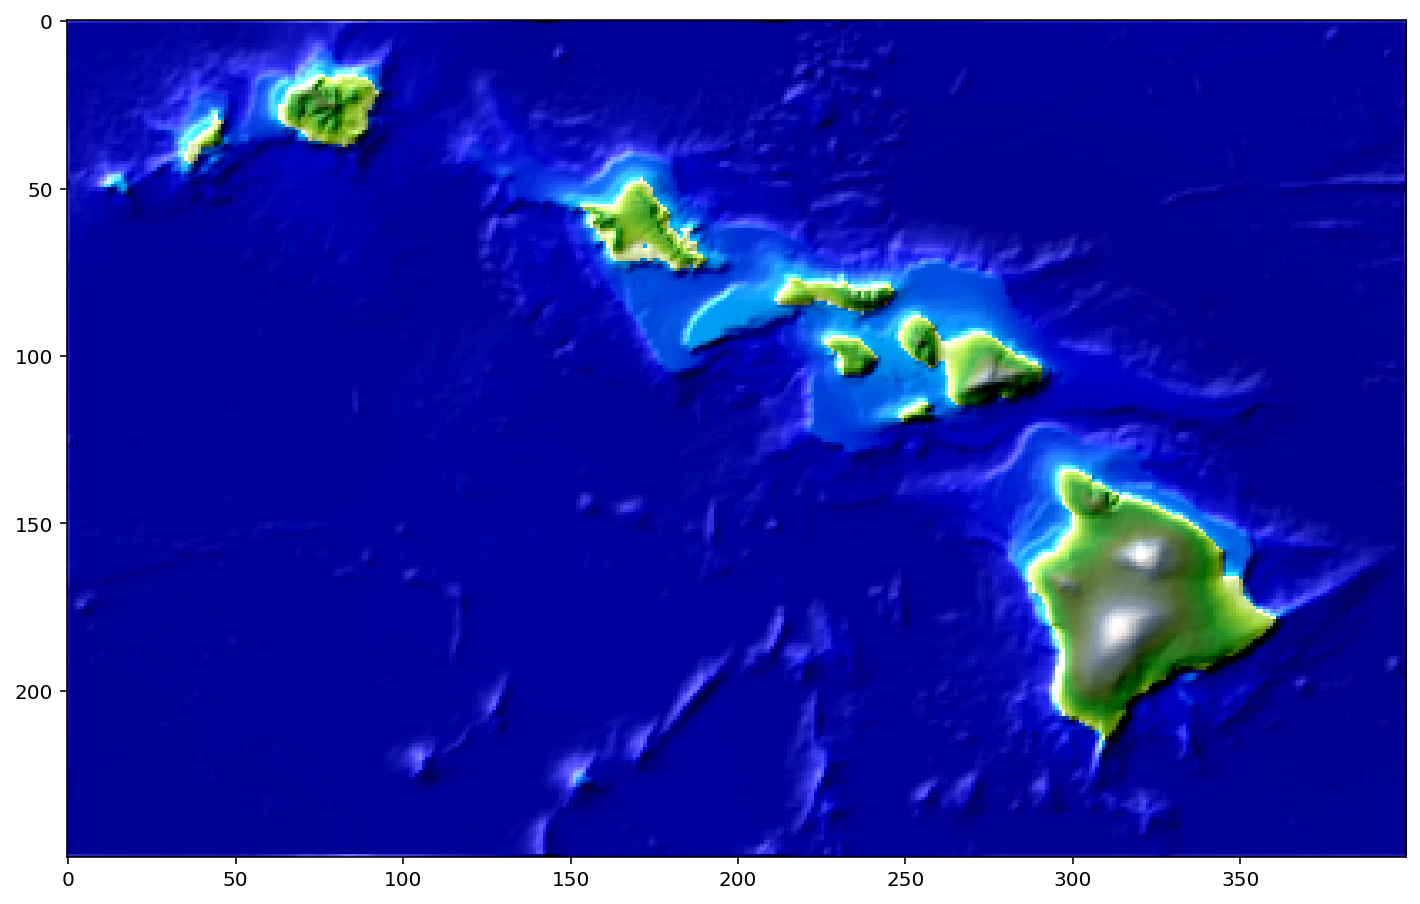

In [2]:
# Load Hawaii
map_elevation = loadRegionMap(region='hawaii', dataset='TBI', minutes_per_node=1, image_folder='img/02/')
data_elevation_sqrt = np.power(np.abs(map_elevation.getDataFlat() * 1.0), 0.5) * np.sign(map_elevation.getDataFlat())
data_elevation_sqrt = data_elevation_sqrt / max(data_elevation_sqrt)
map_elevation_sqrt = map_elevation.newChildInstance(
    {
        'values': 'elevation',
        'mods': 'sqrt'
    }, 
    data_elevation_sqrt
)
map_hillshade = getHillshade(map_elevation, 1)

# Display the image & save the image
RasterImage(map_elevation) \
    .addLayer('elevation', map_elevation_sqrt.getDataFlat(), colormap='naturalish') \
    .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
    .display().final()

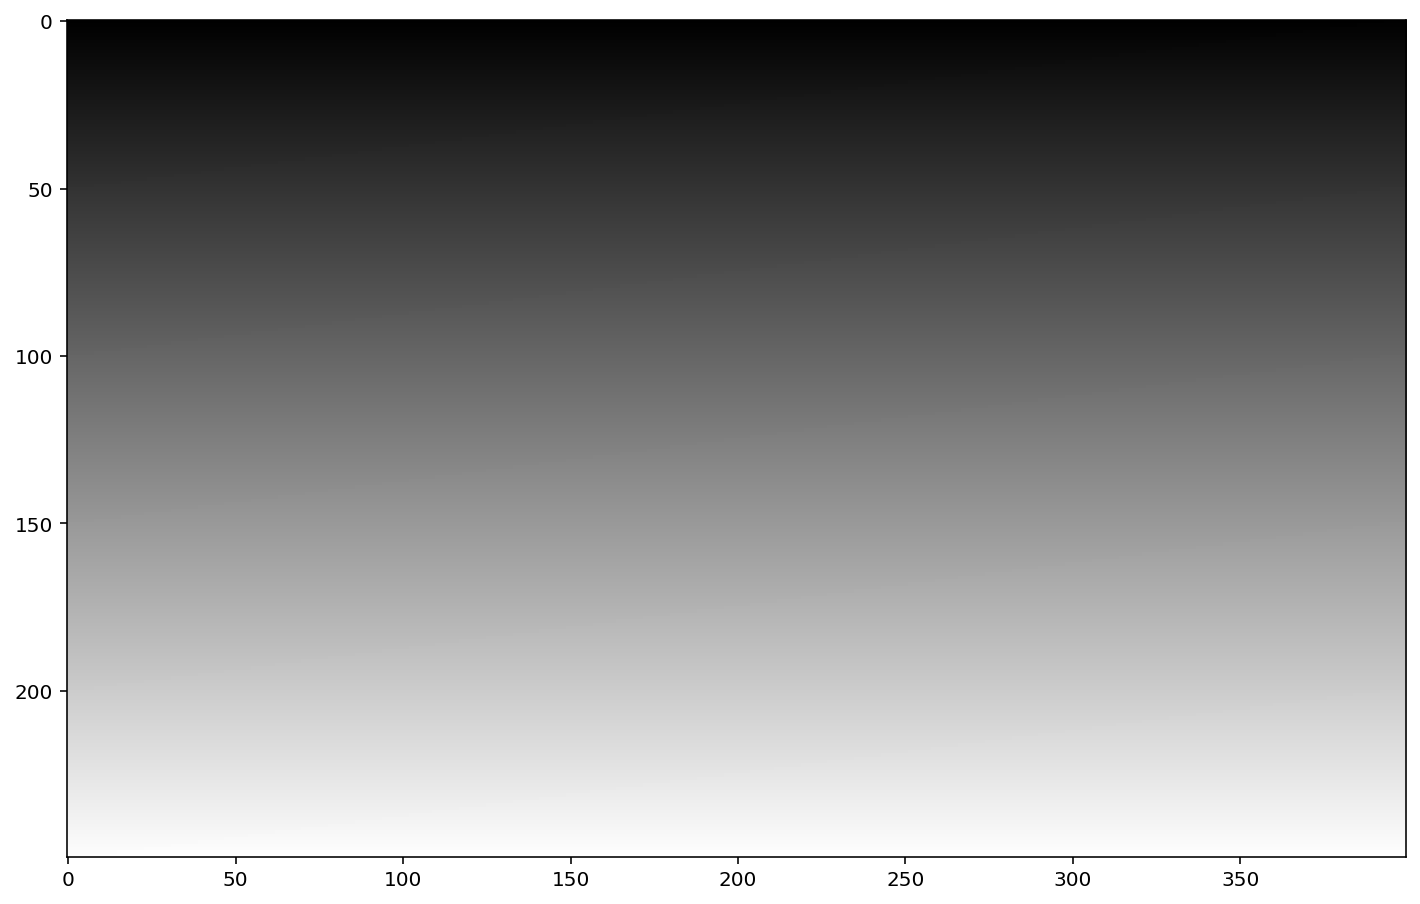

In [3]:
# Method to get the index of each node
nodes_index = getNodesIndex(map_elevation)

RasterImage(map_elevation) \
    .addLayer('index', nodes_index, transforms=['norm']) \
    .display().final()

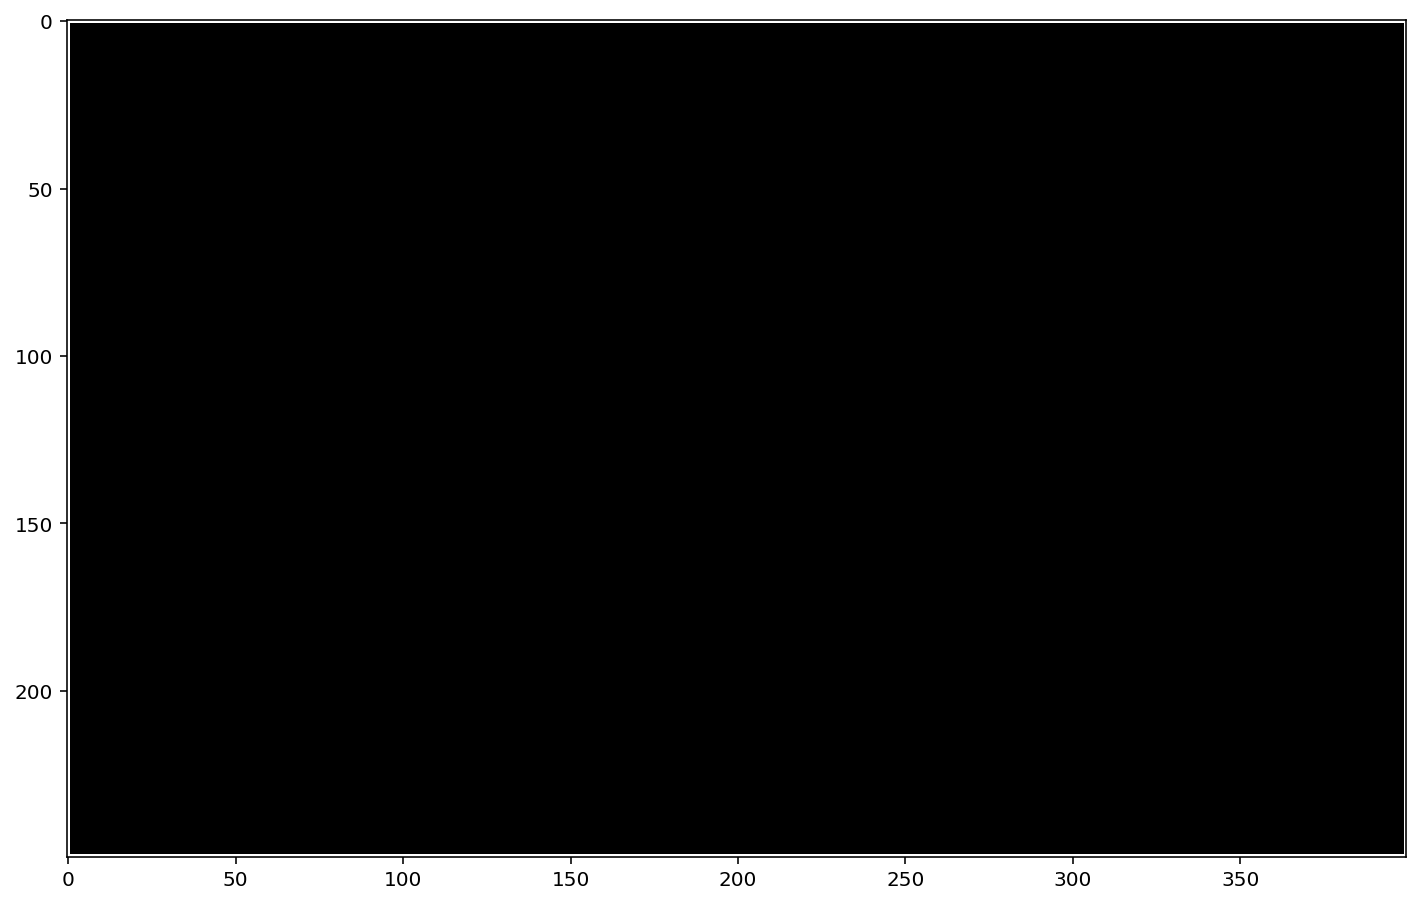

In [4]:
# Method to determine which nodes are at the edge of the map
# It is useful for ignoring "neighboring" nodes that shouldn't be counted in algorithms   
nodes_on_map_edge = getNodesOnMapEdge(map_elevation)

RasterImage(map_elevation) \
    .addLayer('mapedge', nodes_on_map_edge) \
    .display().final()

nodes_value


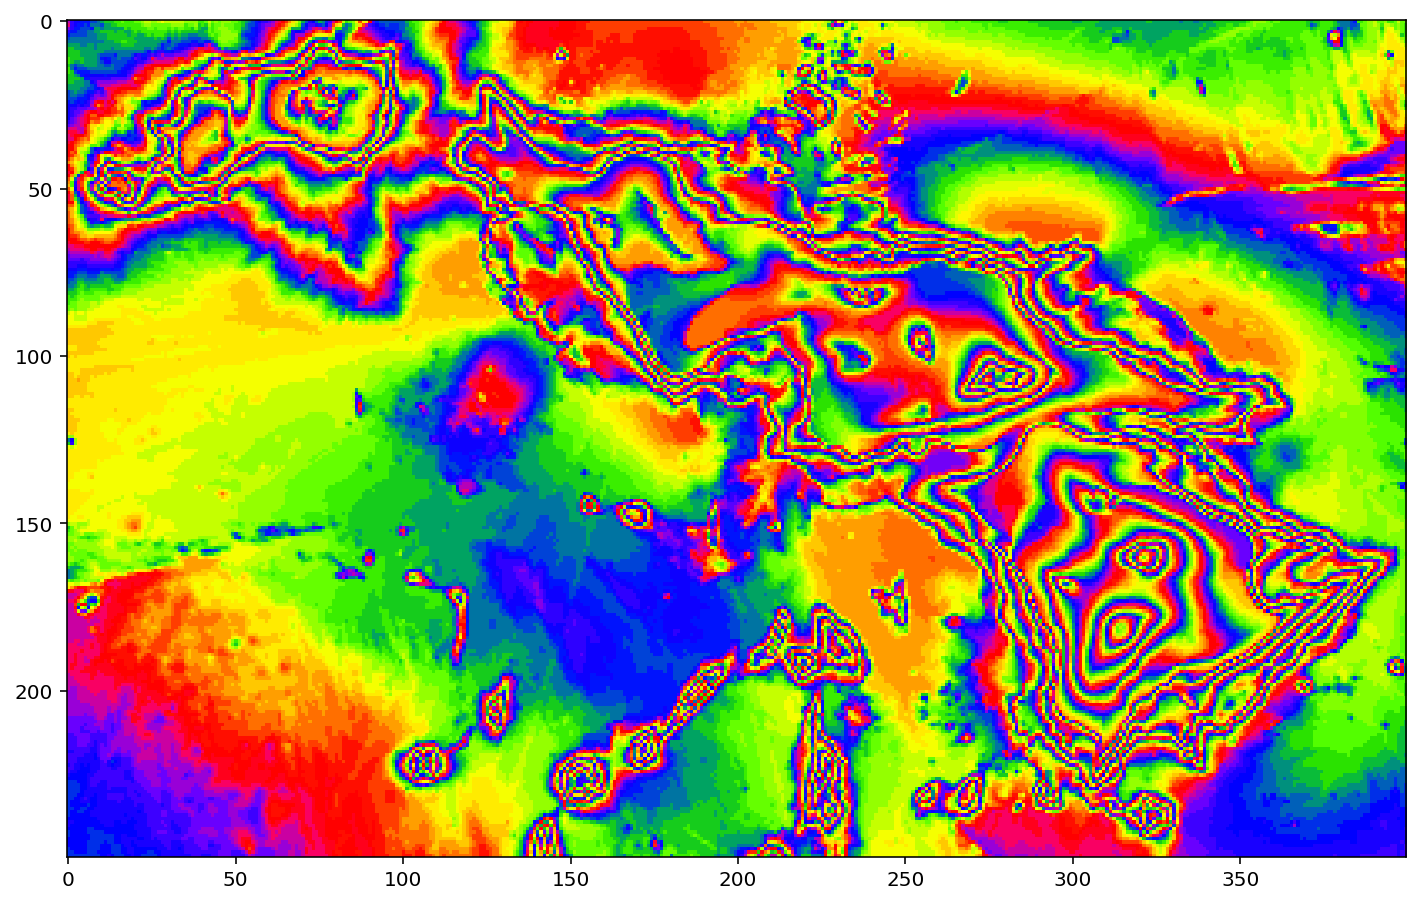

nodes_highest_neighbor_value_so_far


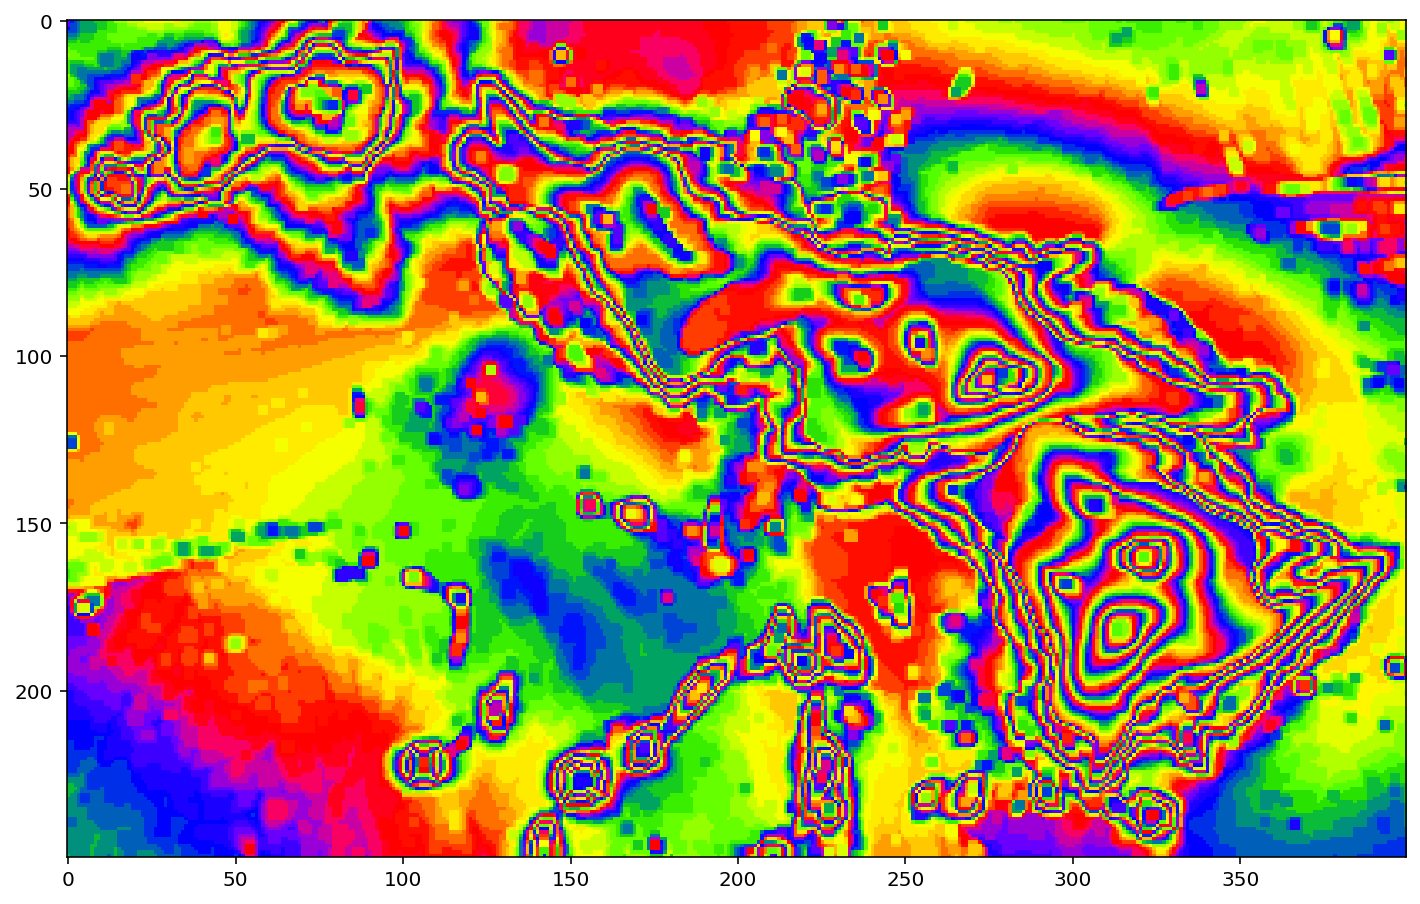

nodes_highest_neighbor_index


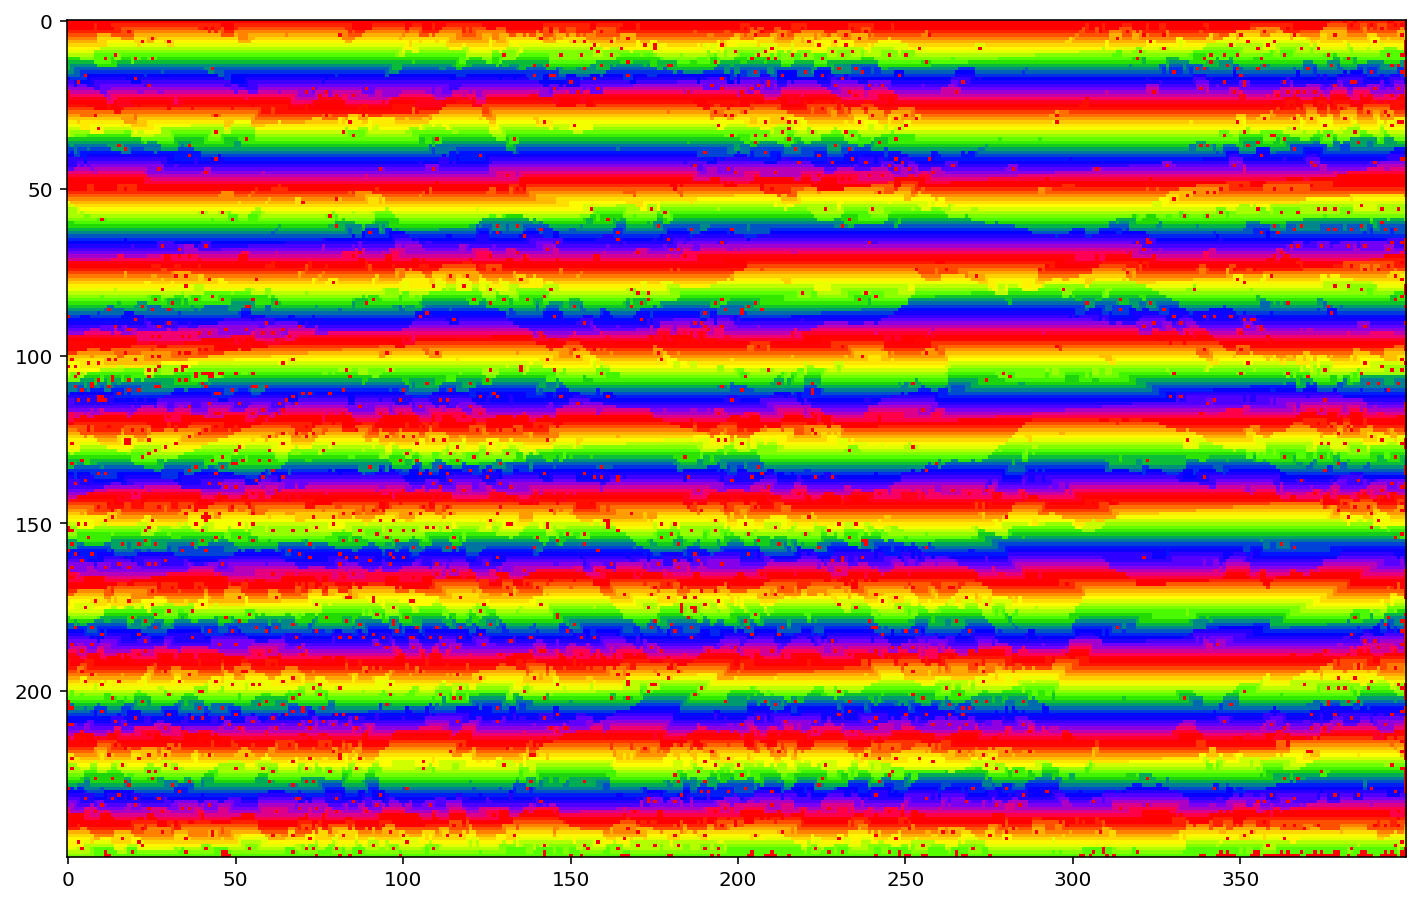

In [5]:
# Test out getting the highest neighbor
map_instance = map_elevation
radius = 1.5 # Adjacent & Orthogonal
wrap = False

nodes_value = map_instance.getDataFlat()
nodes_highest_neighbor_value_so_far = map_instance.getDataFlat()
gridded_node_index = nodes_index.reshape(map_instance.getDims())
gridded_value = map_instance.getDataMatrix()
nodes_highest_neighbor_index = np.full(map_instance.getNumNodes(), -1)

rounded_radius = math.floor(radius)
for x in range(-rounded_radius, rounded_radius+1):
    for y in range(-rounded_radius, rounded_radius+1):
        # Only compute for neighboring edges under the radius
        if((x == 0 and y == 0) or (x**2+y**2)**0.5 > radius):
            continue
            
        # For neighboring nodes, find out if they are higher than the node
        nodes_neighbor_value = np.roll(np.roll(gridded_value, x, 0), y, 1).flatten()
        nodes_neighbor_is_higher = nodes_neighbor_value > nodes_highest_neighbor_value_so_far 

        # Remove higher node designations for neighbors that are on the edge
        if (not wrap):
            nodes_neighbor_on_map_edge = np.roll(np.roll(nodes_on_map_edge.reshape(map_instance.getDims()), x, 0), y, 1).flatten()
            nodes_neighbor_is_higher[nodes_neighbor_on_map_edge] = False
        
        # Record the index of the higher neighboring node
        nodes_neighbor_index = np.roll(np.roll(gridded_node_index, x, 0), y, 1).flatten()
        nodes_highest_neighbor_index[nodes_neighbor_is_higher] = nodes_neighbor_index[nodes_neighbor_is_higher]
        nodes_highest_neighbor_value_so_far[nodes_neighbor_is_higher] = nodes_neighbor_value[nodes_neighbor_is_higher]

print('nodes_value')
RasterImage(map_elevation) \
    .addLayer('higher_index', nodes_value, colormap='prism', transforms=['norm']) \
    .display().final()
print('nodes_highest_neighbor_value_so_far')
RasterImage(map_elevation) \
    .addLayer('higher_index', nodes_highest_neighbor_value_so_far, colormap='prism', transforms=['norm']) \
    .display().final()
print('nodes_highest_neighbor_index')
RasterImage(map_elevation) \
    .addLayer('higher_index', nodes_highest_neighbor_index, colormap='prism', transforms=['norm']) \
    .display().final()

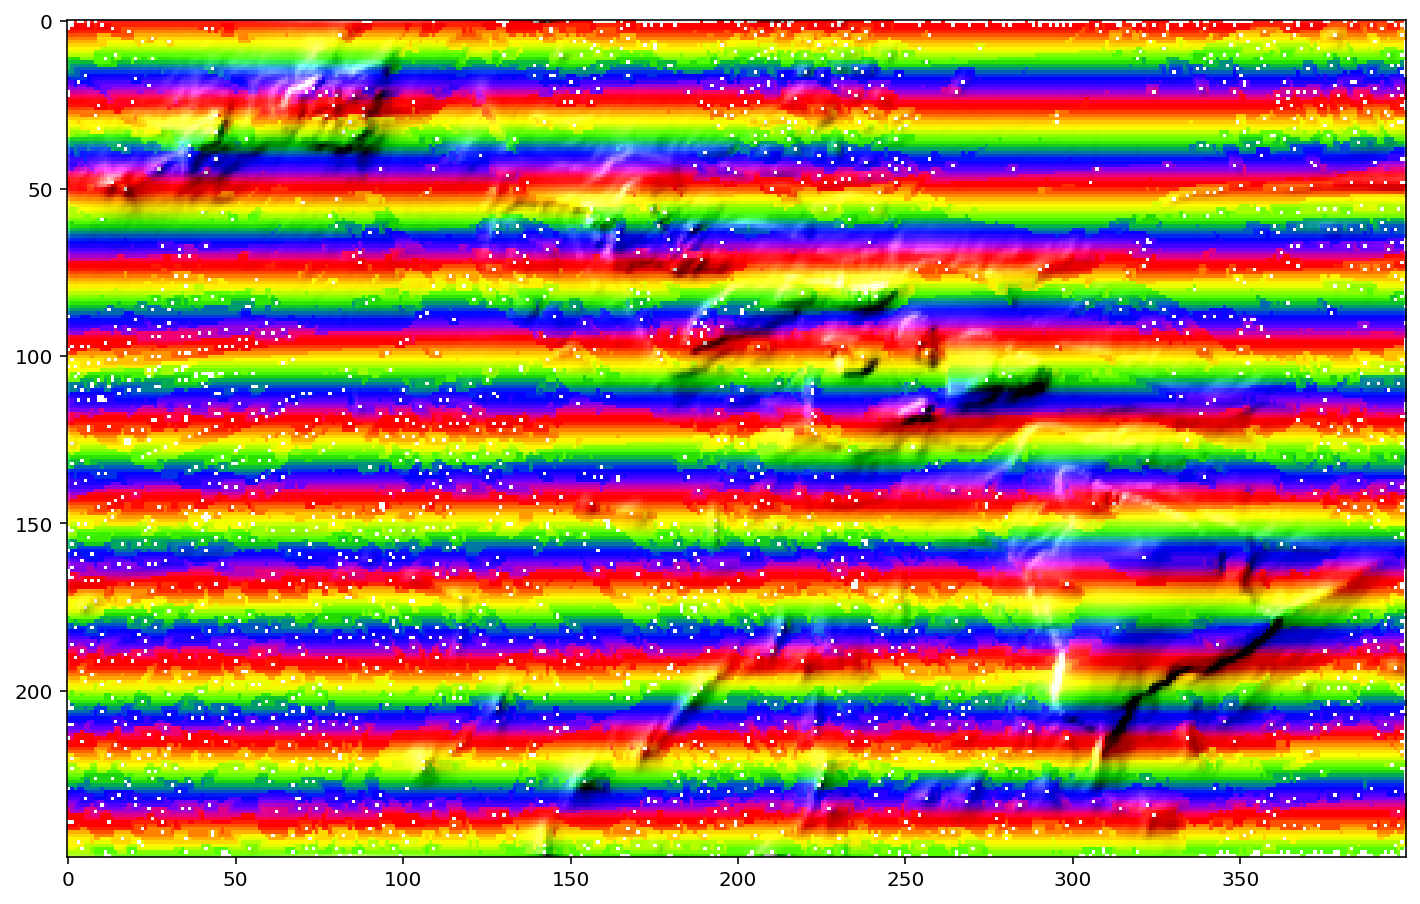

In [6]:
# Move to a library getHighestNeighbor function
map_highest_neighbor_index = getHighestNeighbor(map_elevation)

RasterImage(map_elevation) \
    .addLayer('higher_index', map_highest_neighbor_index.getDataFlat(), colormap='prism', transforms=['norm']) \
    .addLayer('peak', map_highest_neighbor_index.getDataFlat() == -1, combine='add', opacity=1, dissolve=1) \
    .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
    .display().final()


2337 already peaks
86488 updated
74053 updated
56244 updated
35935 updated
16606 updated
4443 updated


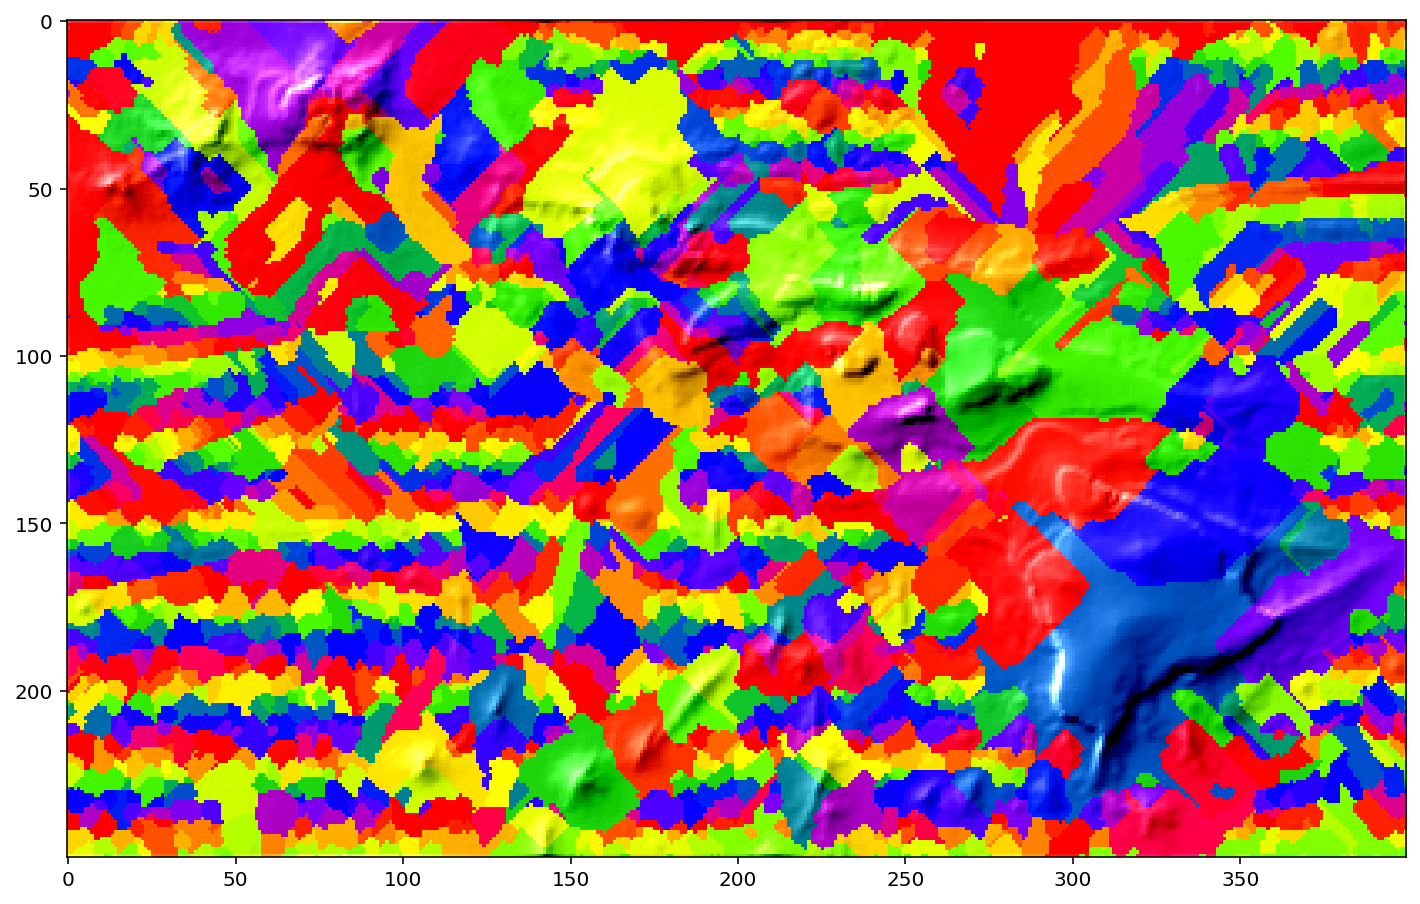

In [7]:
# Get the local peak, the mountain each node would roll up to
map_local_peak = getLocalPeaks(map_highest_neighbor_index, True)

RasterImage(map_elevation) \
    .addLayer('local_peak', map_local_peak.getDataFlat(), colormap='prism', transforms=['norm']) \
    .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
    .display().final()

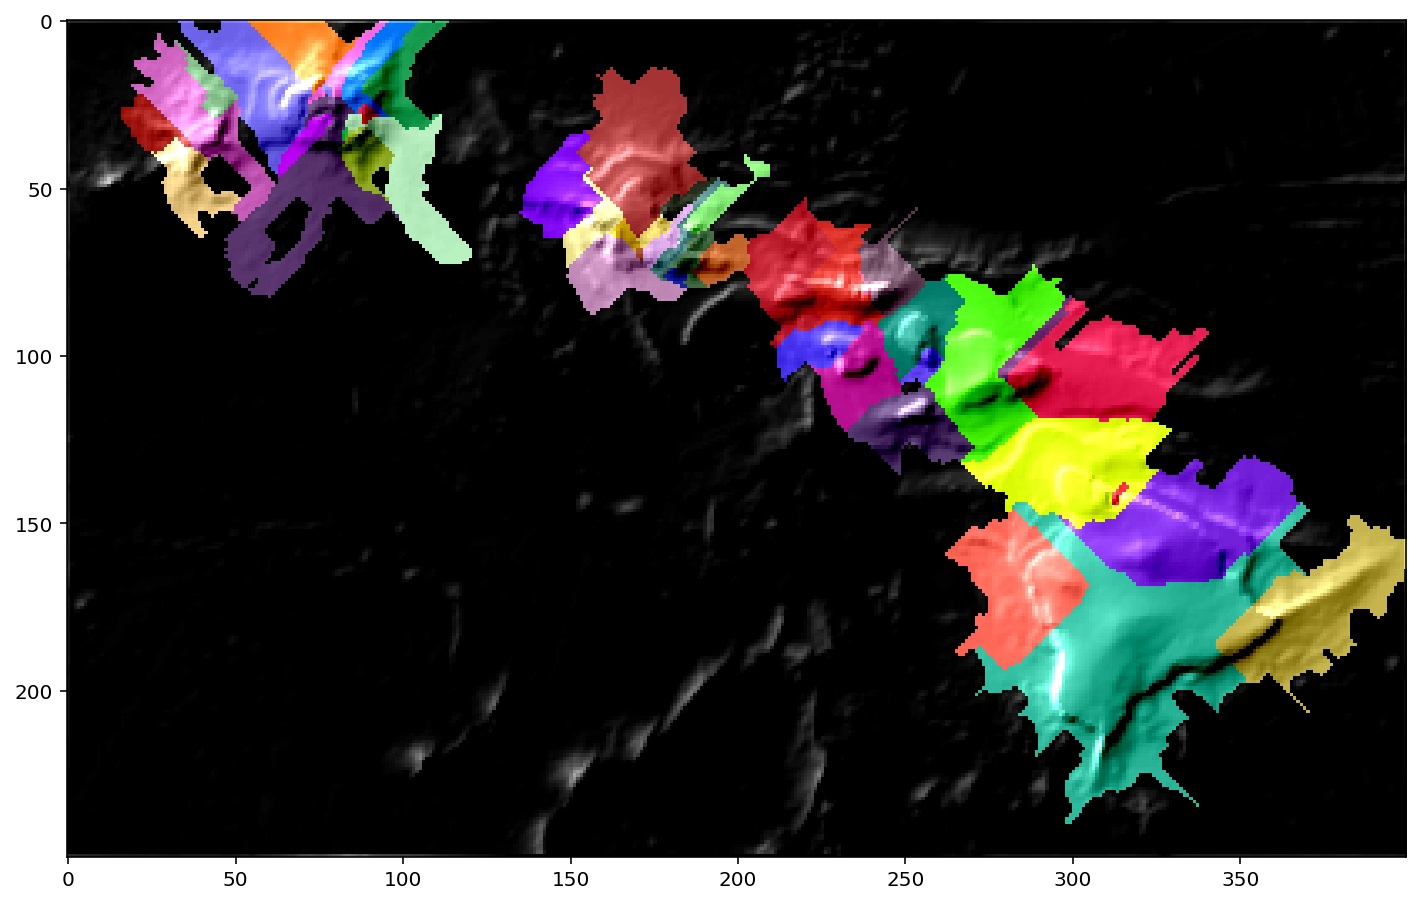

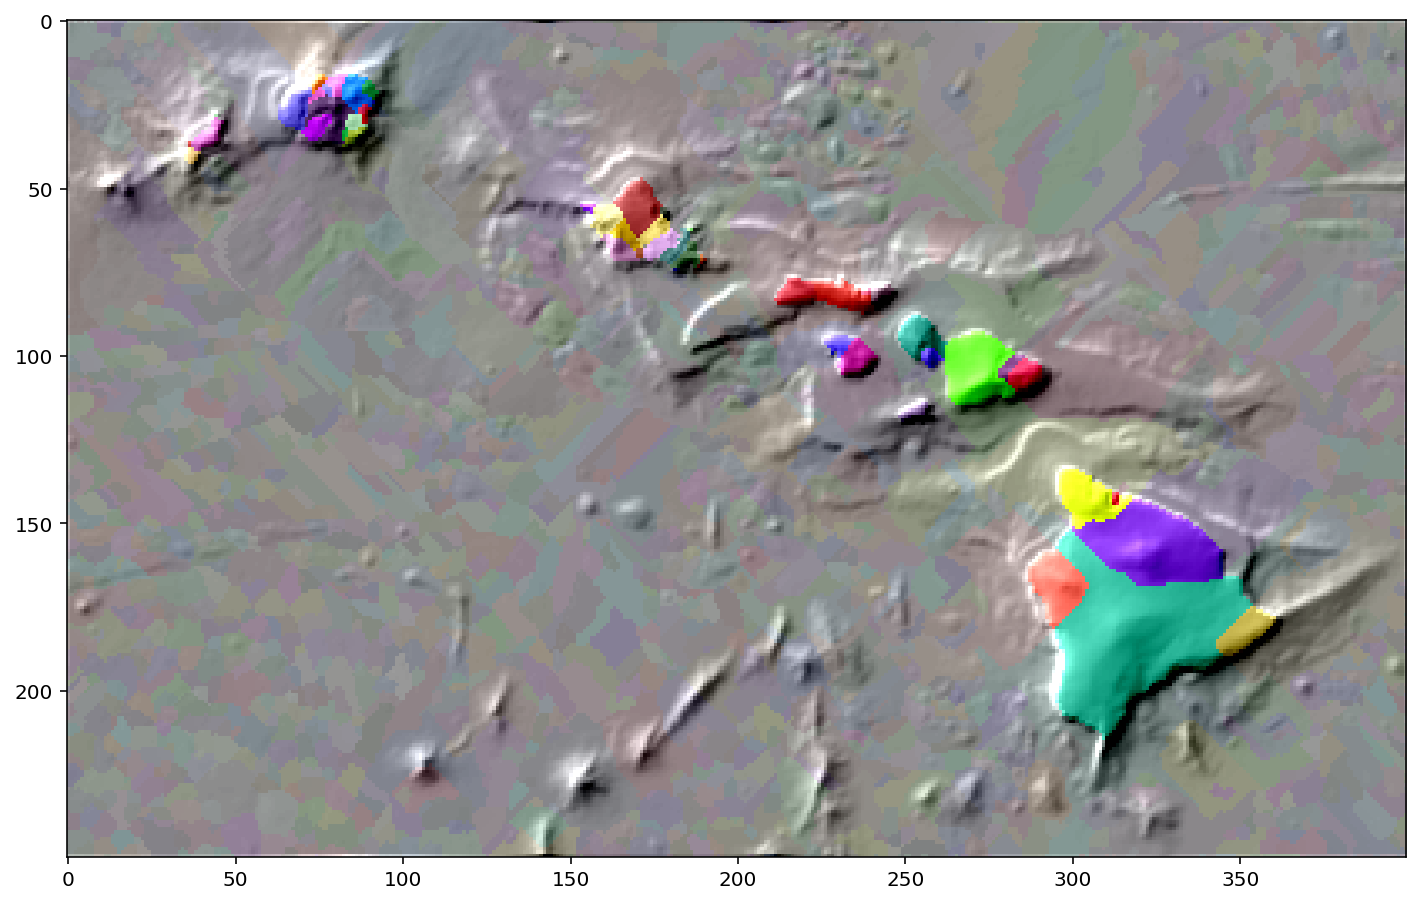

In [8]:
# Try a few other ways to view the mountains in Hawaii

# Only show nodes that roll up to a mountain above sea level
nodes_local_peak_is_above_sealevel = map_elevation.getDataFlat()[map_local_peak.getDataFlat()] > 0
RasterImage(map_elevation) \
    .addLayer('local_peak', map_local_peak.getDataFlat(), colormap='hashed', transforms=['norm']) \
    .addLayer('hasoverwaterpeak', nodes_local_peak_is_above_sealevel, combine='multiply') \
    .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
    .display().final()

# Or modify the nodes below sea level
RasterImage(map_elevation) \
    .addLayer('local_peak', map_local_peak.getDataFlat(), colormap='hashed', transforms=['norm']) \
    .addLayer('brightseas', 1, nodes_selected=map_elevation.getDataFlat() < 0, combine='add', dissolve=.1) \
    .addLayer('hillshade', map_hillshade.getDataFlat(), combine='add', opacity=1, dissolve=1) \
    .display().final()

# None of this is quite working out -- let's try drawing borders between regions instead

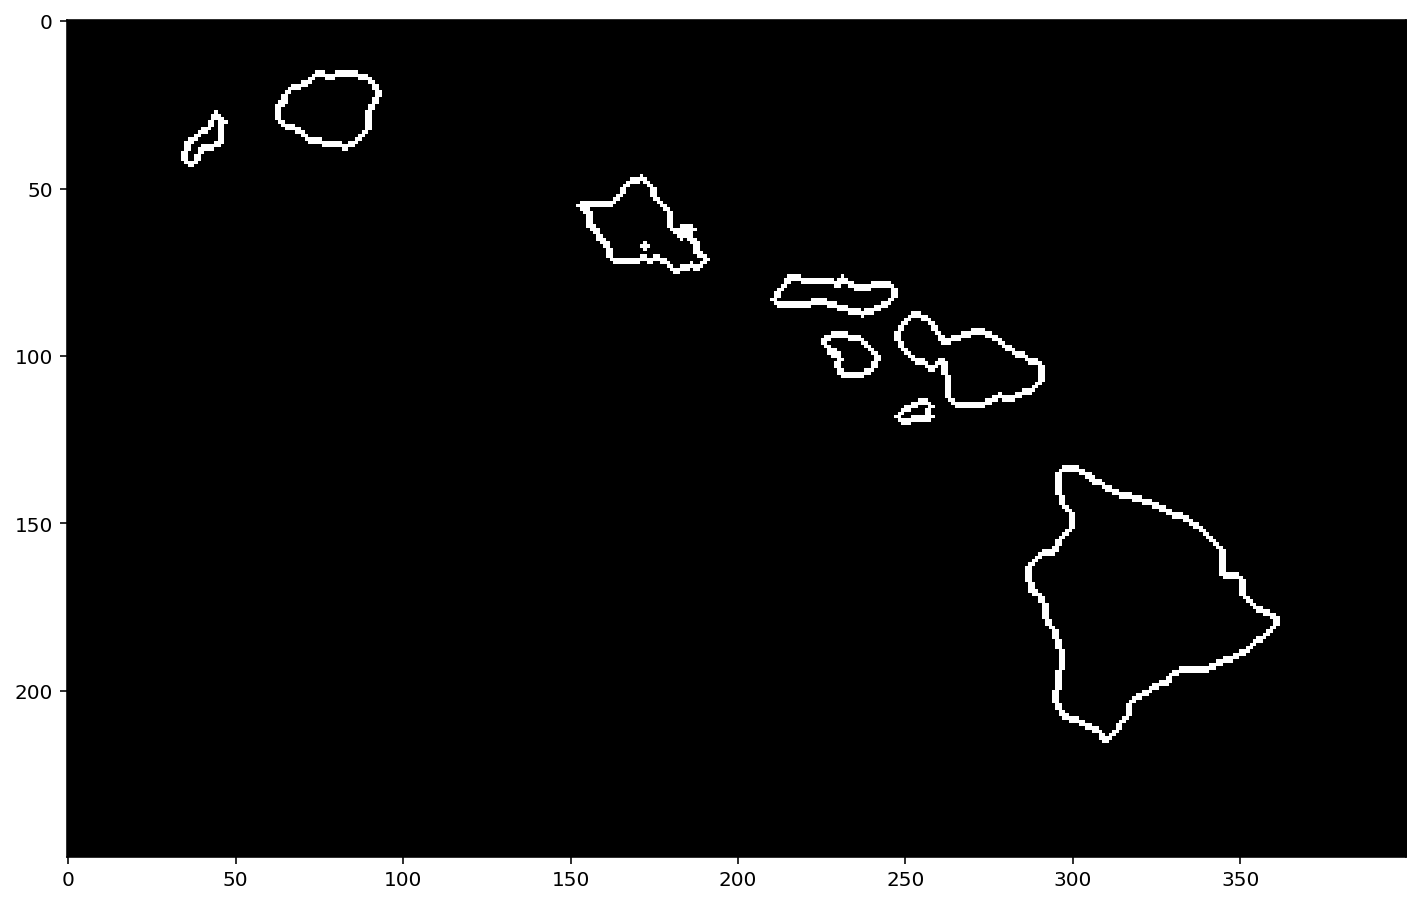

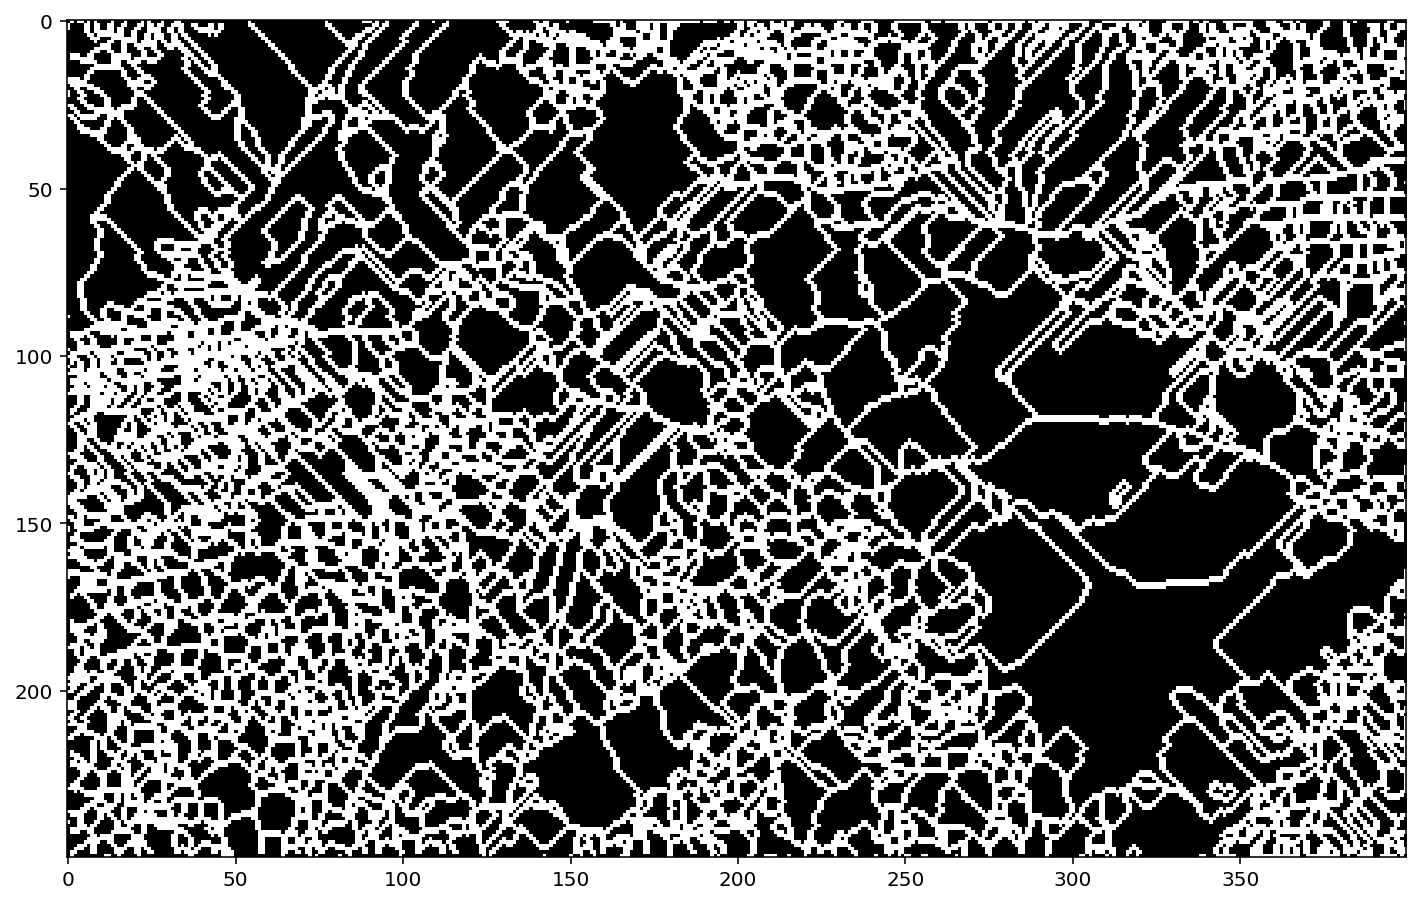

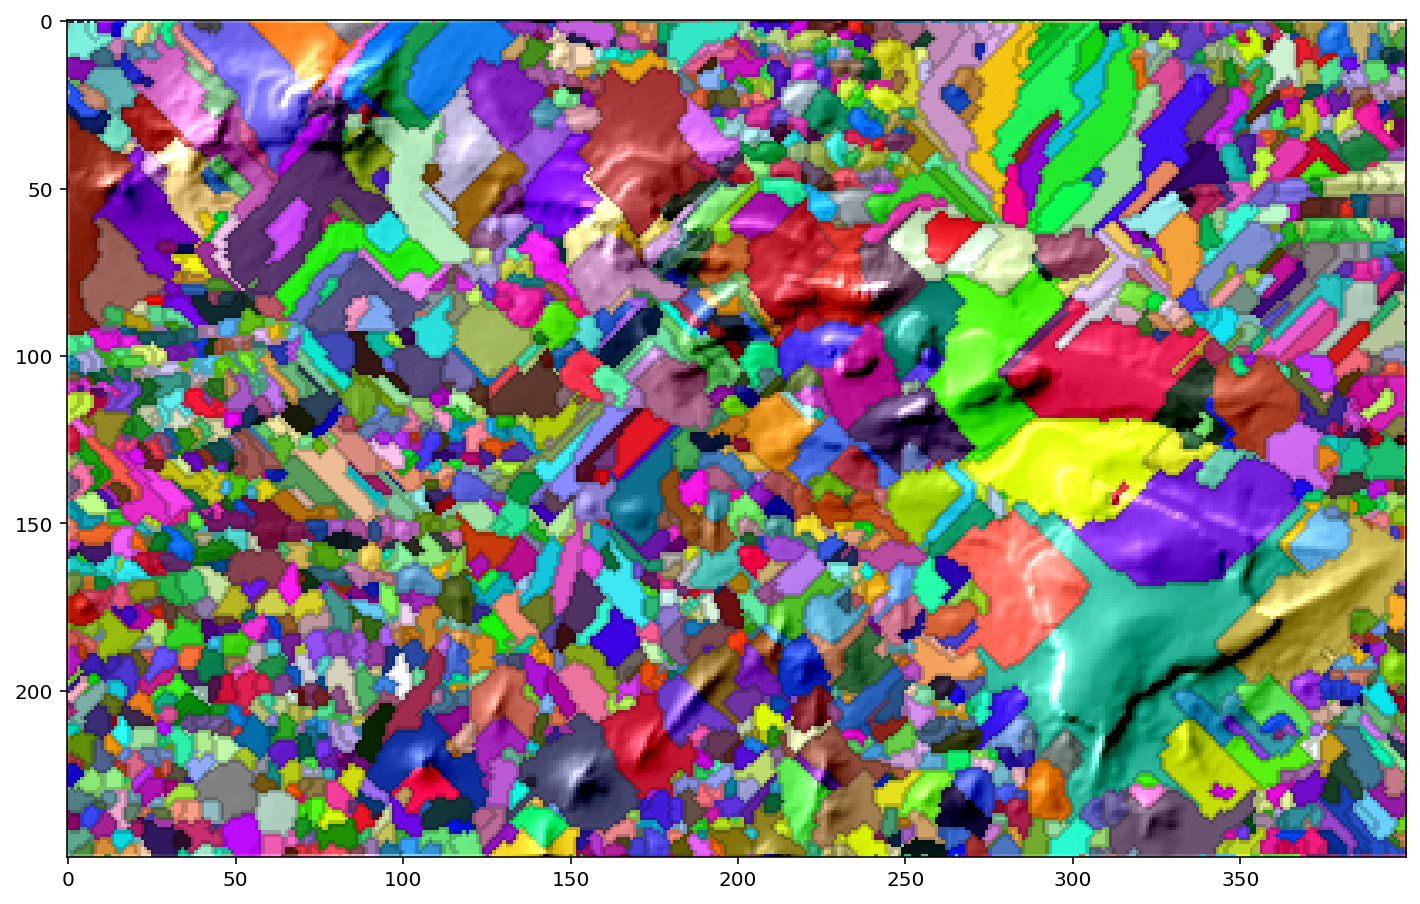

In [9]:
# Get the border
map_local_peak_border = getBorder(map_local_peak, 1)
map_landsea = map_elevation.newChildInstance(
    {'values': 'landmask'},
    map_elevation.getDataFlat() < 0,
)
map_landsea_border = getBorder(map_landsea, 1)

# Make images
RasterImage(map_landsea_border) \
    .addLayer('landsea_border', map_landsea_border.getDataFlat(), transforms=['norm']) \
    .display().final()
RasterImage(map_local_peak_border) \
    .addLayer('local_peak_border', map_local_peak_border.getDataFlat(), transforms=['norm']) \
    .display().final()

RasterImage(map_elevation) \
    .addLayer('local_peak', map_local_peak.getDataFlat(), colormap='hashed', transforms=['norm']) \
    .addLayer('local_peak_border', 0.8, nodes_selected=map_local_peak_border.getDataFlat(), combine='multiply') \
    .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
    .display().final()

In [10]:
# The POP dataset was offset (the arctic and antarctic are empty) so the original data from 2017 left out the extreme latitudes
# That makes the POP dataset incompatible with the TBI/ other elevation datasets so this corrects it.
#
# The code is commented out since it overwrites existing files

## Recompute 1 minute resolution POP data
# Get Data
# dataset = 'POP'
# minutes_per_node = 1
# data_file = open('data/{}_world_{}min.npz'.format(dataset, minutes_per_node), 'rb')
# data_1min = np.load(data_file)['data_matrix']
# data_file.close()

# Save with offset so it covers the whole map
# data_matrix = np.zeros([10800* 21600])
# data_matrix[300* 21600:9000* 21600]=data_1min.flatten()
# file_out = open('data/{}_world_{}min.npz'.format(dataset, minutes_per_node), 'wb')
# np.savez_compressed(file_out, data_matrix=data_matrix.reshape([10800, 21600]))
# file_out.close()

In [11]:
# Make more Datasets
#
# Since we re-generated the 1 minute resolution POP dataset, we need to redo the 5 minute version
# While we are here, we can make 10 minute and 60 minute (1 degree) maps too

def generateCompressedDataset(dataset, minutes_per_node_old, minutes_per_node_new): 
    data_file = open('data/{}_world_{}min.npz'.format(dataset, minutes_per_node_old), 'rb')
    gridded_values_original = np.load(data_file)['data_matrix']
    data_file.close()

    # Recompress it
    compression_ratio = minutes_per_node_new // minutes_per_node_old
    [n_rows, n_cols] = gridded_values_original.shape
    n_nodes = n_rows * n_cols
    nodes_value = np.zeros([n_nodes // (compression_ratio ** 2)])
    for x in range(compression_ratio):
        for y in range(compression_ratio):
            nodes_value += gridded_values_original[0:-1:compression_ratio, 0:-1:compression_ratio].flatten()
            
    # Scale elevation (since it should be smoothed). Population does not get scaled, because that just means it there are more people
    if (dataset != 'POP'):
        nodes_value /= (compression_ratio ** 2)
        
    file_out = open('data/{}_world_{}min.npz'.format(dataset, minutes_per_node_new), 'wb')
    np.savez_compressed(file_out, data_matrix=nodes_value.reshape([n_rows//compression_ratio, n_cols//compression_ratio]))
    file_out.close()
    
# generateCompressedDataset('POP', 1, 5)
# generateCompressedDataset('POP', 5, 10)
# generateCompressedDataset('POP', 5, 60)
# generateCompressedDataset('TBI', 5, 10)
# generateCompressedDataset('TBI', 5, 60)

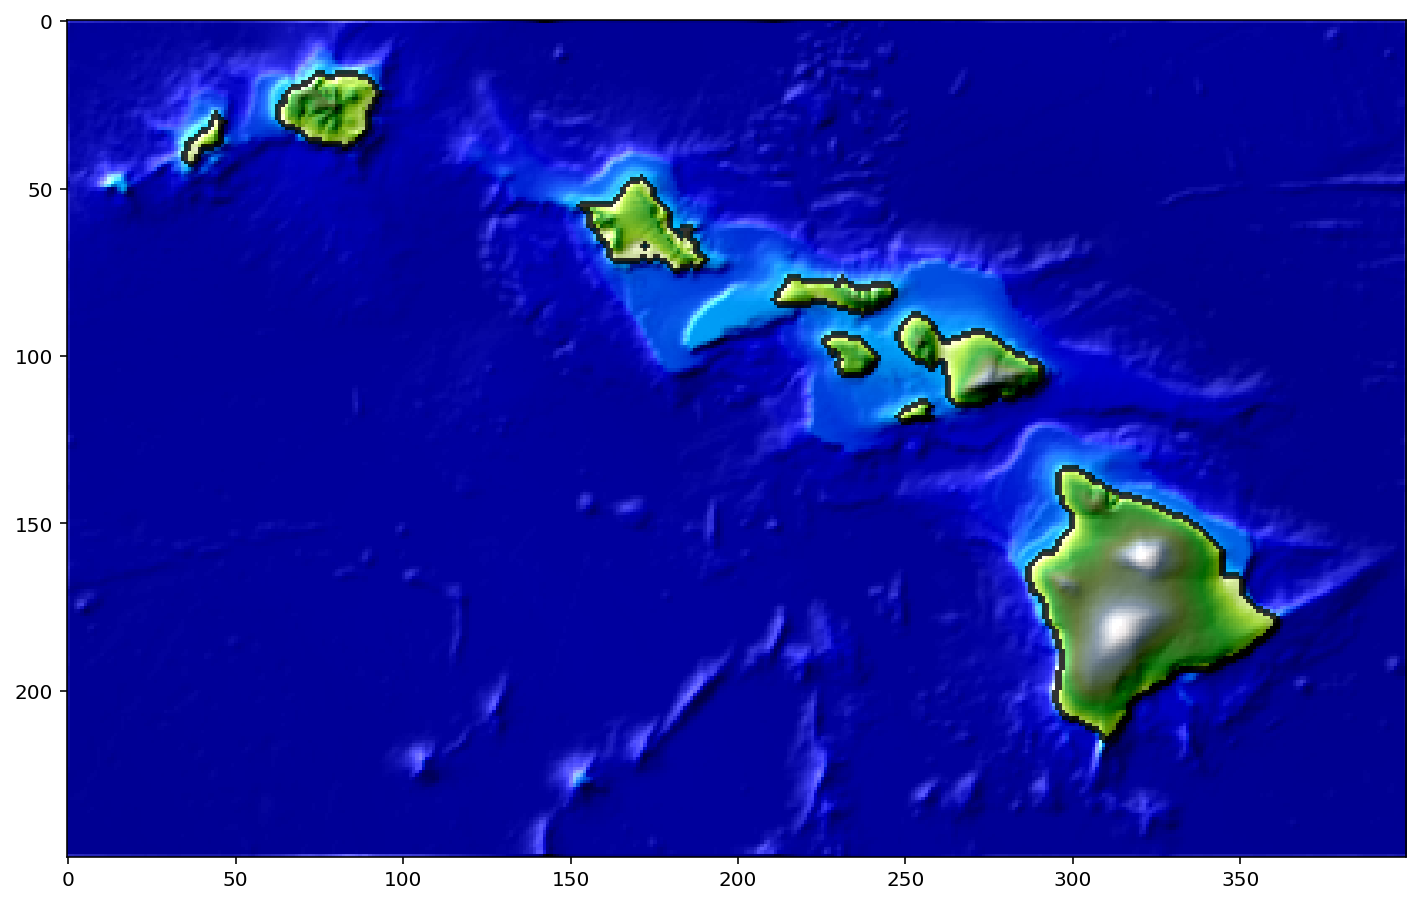

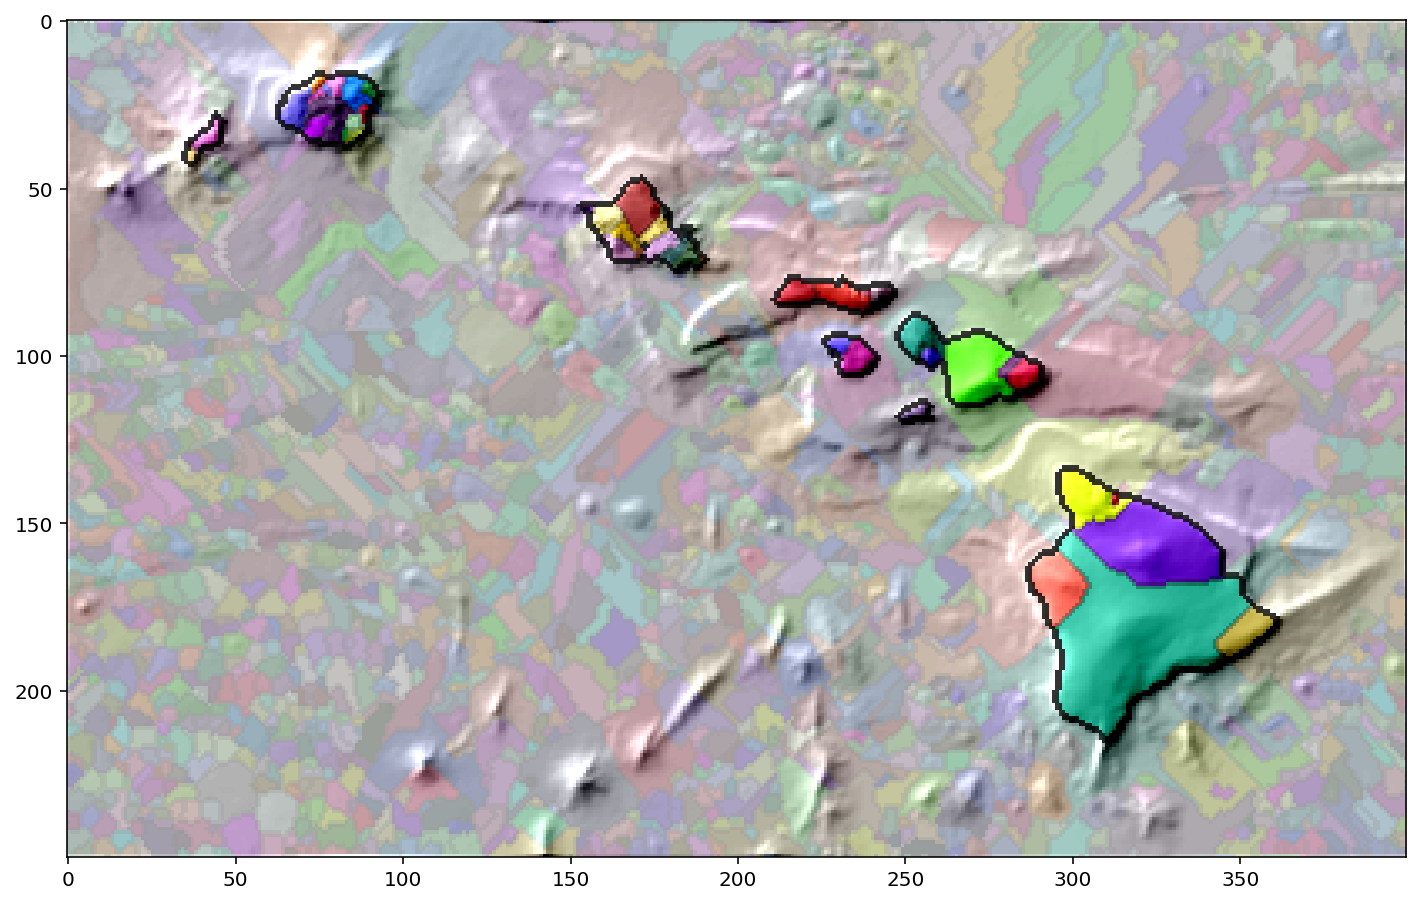

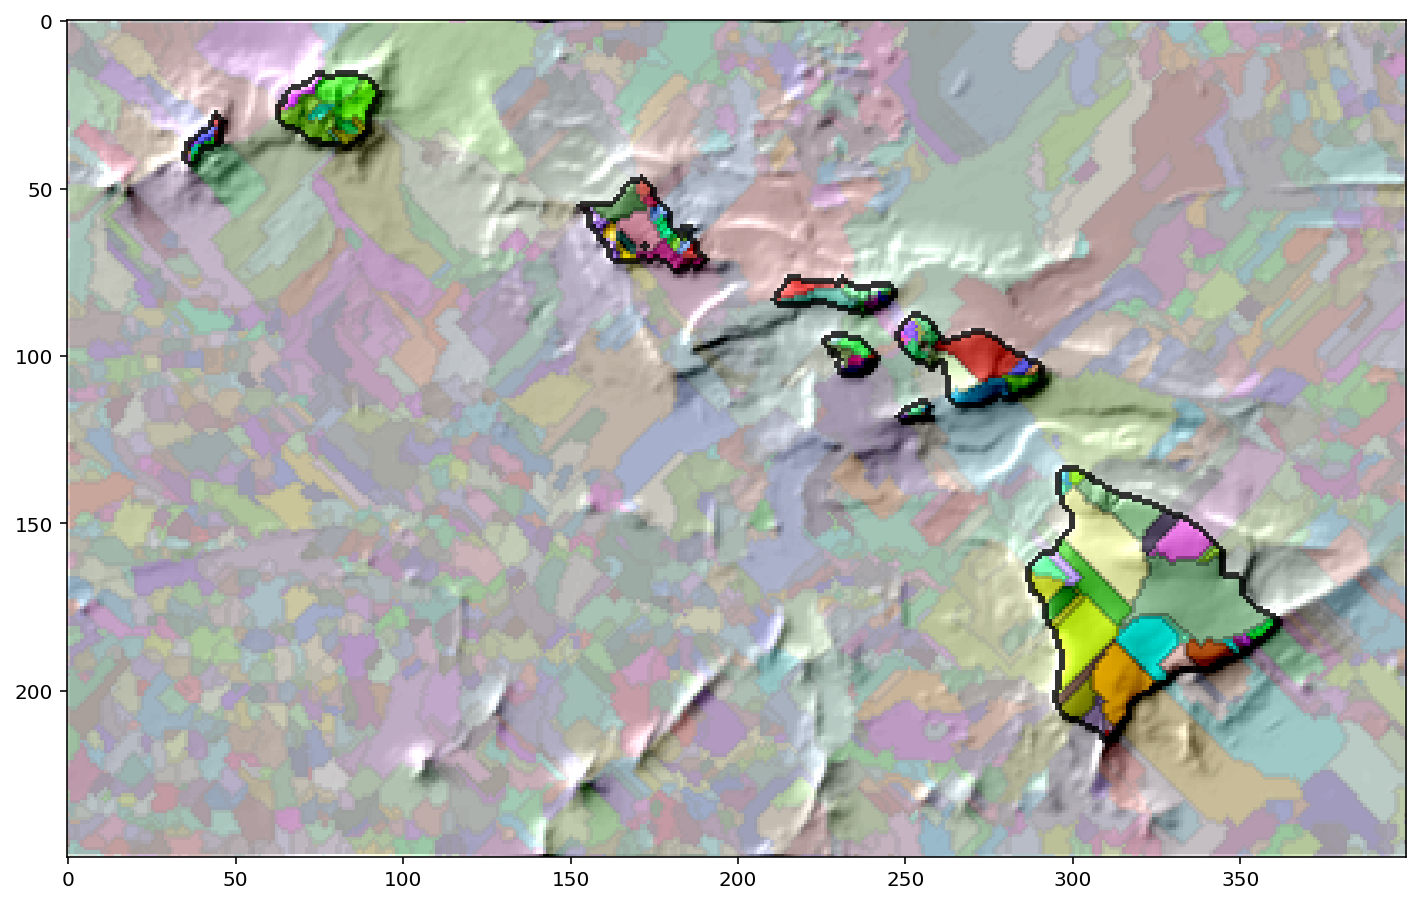

In [12]:
# Redo the whole process in a single frame, make pretty images, and perform the algorithm on the map depth too to construct simple basins
def computeMountainsAndBasins(dataset, region, minutes_per_node):
    map_elevation = loadRegionMap(region=region, dataset=dataset, minutes_per_node=minutes_per_node, image_folder='img/02/')
    map_elevation_display = None
    nodes_elevation_display = np.power(np.abs(map_elevation.getDataFlat() * 1.0), 0.5) * np.sign(map_elevation.getDataFlat())
    nodes_elevation_display = nodes_elevation_display / max(data_elevation_sqrt)
    if (dataset == 'POP'):
        nodes_elevation_display[nodes_elevation_display == 0] = -1
    map_elevation_display = map_elevation.newChildInstance(
        {
            'values': 'elevation',
            'mods': 'sqrt'
        }, 
        nodes_elevation_display
    )
    map_hillshade = getHillshade(map_elevation, 1)
    map_landsea = map_elevation.newChildInstance(
        {'values': 'landmask'},
        map_elevation.getDataFlat() < 0,
    )
    map_landsea_border = getBorder(map_landsea, 1)
    RasterImage(map_elevation) \
        .addLayer('elevation', map_elevation_display.getDataFlat(), colormap='naturalish') \
        .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
        .addLayer('coast', .2, nodes_selected=map_landsea_border.getDataFlat(), combine='multiply') \
        .display().overrideLayerNames(['elevation']).save().final()

    # Mountains
    map_highest_neighbor_index = getHighestNeighbor(map_elevation)
    map_mountain = getLocalPeaks(map_highest_neighbor_index)
    map_mountain_border = getBorder(map_mountain, 1)
    RasterImage(map_elevation) \
        .addLayer('base', 1) \
        .addLayer('mountain_border', 0.7, nodes_selected=map_mountain_border.getDataFlat()) \
        .addLayer('mountain', map_mountain.getDataFlat(), colormap='hashed', transforms=['norm'], combine='multiply', opacity=0.5) \
        .addLayer('sea', 1.2, nodes_selected=map_elevation.getDataFlat() < 0, combine='add', dissolve=.2) \
        .addLayer('hillshade', map_hillshade.getDataFlat(), combine='add', opacity=1, dissolve=1) \
        .addLayer('coast', .2, nodes_selected=map_landsea_border.getDataFlat(), combine='multiply') \
        .display().overrideLayerNames(['mountains']).save().final()

    # Basins
    map_depth = map_elevation.newChildInstance(
        {'values': 'depth'},
        -map_elevation.getDataFlat(),
    )
    map_lowest_neighbor_index = getHighestNeighbor(map_depth)
    map_basin = getLocalPeaks(map_lowest_neighbor_index)
    map_basin_border = getBorder(map_basin, 1)
    RasterImage(map_elevation) \
        .addLayer('base', 1) \
        .addLayer('basin_border', 0.7, nodes_selected=map_basin_border.getDataFlat()) \
        .addLayer('basin', map_basin.getDataFlat(), colormap='hashed', transforms=['norm'], combine='multiply', opacity=0.5) \
        .addLayer('sea', 1.2, nodes_selected=map_landsea.getDataFlat(), combine='add', dissolve=.2) \
        .addLayer('hillshade', map_hillshade.getDataFlat(), combine='add', opacity=1, dissolve=1) \
        .addLayer('coast', .2, nodes_selected=map_landsea_border.getDataFlat(), combine='multiply') \
        .display().overrideLayerNames(['basins']).save().final()

# Generate images for various combinations of data
# computeMountainsAndBasins('TBI', 'cascadia', 1)
# computeMountainsAndBasins('TBI', 'cascadia', 5)
# computeMountainsAndBasins('TBI', 'cascadia', 10)
computeMountainsAndBasins('TBI', 'hawaii', 1)
# computeMountainsAndBasins('TBI', 'world', 10)
# computeMountainsAndBasins('TBI', 'world', 60)
# computeMountainsAndBasins('POP', 'cascadia', 1)
# computeMountainsAndBasins('POP', 'hawaii', 1)
# computeMountainsAndBasins('POP', 'world', 10)
# computeMountainsAndBasins('POP', 'world', 60)